In [1]:
import h5py
import os
import sys
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## LOAD DATASET

In [2]:
label_names=['Bauteil-007', 'Bauteil-013', 'Bauteil-014', 'Bauteil-017', 'Bauteil-020', 'Bauteil-021', 'Bauteil-025','Bauteil-027', 'Bauteil-029', 'Bauteil-030']

In [7]:
list_dir= os.listdir()
points=[]
labels=[]
for file_name in list_dir:
    if file_name.endswith("10_2048data_train.h5"):
        f=h5py.File(os.path.join("", file_name), 'r+')
        points_file=f["data"][:]
        labels_file=f["label"][:]
        f.close()
        points.extend(list(points_file))
        labels.extend(list(labels_file))
print(len(points))

1910


In [6]:
list_dir= os.listdir()
test_points=[]
test_labels=[]
for file_name in list_dir:
    if file_name.endswith("10_2048data_test.h5"):
        f=h5py.File(os.path.join("", file_name), 'r+')
        points_file=f["data"][:]
        labels_file=f["label"][:]
        f.close()
        test_points.extend(list(points_file))
        test_labels.extend(list(labels_file))
print(len(test_points))

560


Look at dataset

In [11]:
i=np.random.randint(0,len(points))
print(label_names[labels[i]])
pcd = o3d.geometry.PointCloud()
pcd.points= o3d.utility.Vector3dVector(points[i])
o3d.visualization.draw_geometries([pcd])

Bauteil-025


Statistical view of dataset

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

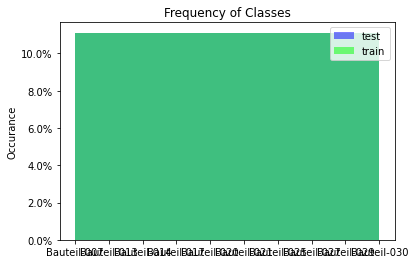

In [13]:
# def addlabels(x,y):
#     for i in range(len(x)):
#         plt.text(i,y[i],y[i])


labels_1=np.asarray(test_labels)
labels_2=np.asarray(labels)
unique_1=np.unique(labels_1)
unique_2=np.unique(labels_2)
plt.ylabel('Occurance')
plt.title('Frequency of Classes')
hist1=plt.hist(labels_1,bins=len(unique_1),alpha=0.5, label="test", density=True, color=[0,0,1])
hist2=plt.hist(labels_2,bins=len(unique_2),alpha=0.5, label="train", density=True, color=[0,1,0])
# print(hist1)
plt.xticks(ticks=unique_1 ,labels=label_names)
plt.legend(loc='upper right')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.show()

##TEST ML MODEL

In [14]:
import torch
from model import DGCNN_cls
import argparse

In [15]:
parser = argparse.ArgumentParser(description='Point Cloud Recognition')
parser.add_argument('--k', type=int, default=20, metavar='N',
                        help='Num of nearest neighbors to use')
parser.add_argument('--emb_dims', type=int, default=2048, metavar='N',
                        help='Dimension of embeddings')
parser.add_argument('--dropout', type=float, default=0.5,
                        help='initial dropout rate')
args = parser.parse_args(args=[])

In [16]:
model_path=os.path.join("trained\cls_2048_eval\models\model.pth")

model=torch.nn.DataParallel(DGCNN_cls(args))
load_model=torch.load(model_path, map_location='cpu')
model.load_state_dict(load_model)
model.eval()

DataParallel(
  (module): DGCNN_cls(
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Sequential(
      (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv3): Sequential(
      (

In [32]:
i=np.random.randint(0,len(points))

pcd = o3d.geometry.PointCloud()
pcd.points= o3d.utility.Vector3dVector(points[i])
o3d.visualization.draw_geometries([pcd])
# print(type(points[i]))
# print(torch.tensor(points[i].T.reshape([1,3,2048])).shape)
# in_points=torch.tensor(points[i][:1024].T.reshape([1,3,1024]))
output=model(torch.tensor(points[i].T.reshape([1,3,2048])))[0]
prediction=torch.argmax(output,axis=0)
confidence=1-(torch.mean(torch.abs(output))/output[prediction])
print(f"prediction: {label_names[labels[prediction]]} with the confidence of {confidence} actual: {label_names[labels[i]]}")

prediction: Bauteil-025 with the confidence of 0.948934018611908 actual: Bauteil-017
